In [ ]:
# Install compatible versions of required libraries
!pip install -q transformers==4.28.1 datasets seaborn numpy pandas scikit-learn matplotlib torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.0/110.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 65.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 125.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00


#Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from torch.optim import AdamW

from transformers import (
    DistilBertTokenizer,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset

#Configuration and Device Setup

In [ ]:
# Set the number of samples to use and device type
num_value = 500
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


#Load and Preprocess IMDb Dataset

In [ ]:
# Load IMDb dataset
print("Loading IMDb dataset...")
dataset = load_dataset("imdb")

# Prepare balanced training and validation subsets
train_texts = dataset["train"]["text"][:num_value] + dataset["train"]["text"][13000:13000 + num_value]
train_labels = dataset["train"]["label"][:num_value] + dataset["train"]["label"][13000:13000 + num_value]

val_texts = dataset["test"]["text"][:num_value] + dataset["test"]["text"][13000:13000 + num_value]
val_labels = dataset["test"]["label"][:num_value] + dataset["test"]["label"][13000:13000 + num_value]

print(f"Train size: {len(train_texts)}, Val size: {len(val_texts)}")

Loading IMDb dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Train size: 1000, Val size: 1000


#Tokenizer Initialization

In [ ]:
# Load tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_len = 128

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
# Define custom dataset class for IMDb
class ImdbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])
        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

#Prepare DataLoaders

In [ ]:
# Initialize datasets and dataloaders
train_dataset = ImdbDataset(train_texts, train_labels, tokenizer, max_len)
val_dataset = ImdbDataset(val_texts, val_labels, tokenizer, max_len)

batch_size = 16
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

#Load Model, Optimizer, and Scheduler

In [ ]:
# Load pre-trained DistilBERT model for classification
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    output_attentions=True
).to(device)

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'pre_classifier.

#Training and Evaluation Functions

In [ ]:
!pip install tqdm
from tqdm import tqdm

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    # Wrap dataloader in tqdm for progress bar
    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids    = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels       = batch['label'].to(device)

        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss   = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy, all_preds, all_labels


def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_attentions = [], [], []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            logits = outputs.logits
            attentions = outputs.attentions

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1).flatten()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            for att_layer in attentions:
                all_attentions.append(att_layer.cpu().numpy())

    return total_loss / len(dataloader), accuracy_score(all_labels, all_preds), all_preds, all_labels, all_attentions

#Train and Evaluate Model

In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

print("Starting training...")
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")

    # TRAINING with progress bar inside train_epoch
    train_loss, train_accuracy, _, _ = train_epoch(
        model, train_dataloader, optimizer, scheduler, device
    )

    # VALIDATION (no progress bar)
    val_loss, val_accuracy, val_preds, val_labels, attentions = evaluate(
        model, val_dataloader, device
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Train Loss: {train_loss:.4f} | Accuracy: {train_accuracy:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Accuracy: {val_accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(
        val_labels, val_preds,
        target_names=['Negative', 'Positive'],
        labels=[0, 1]
    ))

Starting training...

Epoch 1/3


Train Loss: 0.6268 | Accuracy: 0.6390
Val   Loss: 0.4955 | Accuracy: 0.7780

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.76      0.77       500
    Positive       0.77      0.80      0.78       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000


Epoch 2/3


Train Loss: 0.3652 | Accuracy: 0.8490
Val   Loss: 0.4220 | Accuracy: 0.8030

Classification Report:
              precision    recall  f1-score   support

    Negative       0.82      0.77      0.80       500
    Positive       0.79      0.83      0.81       500

    accuracy                           0.80      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.80      0.80      0.80      1000


Epoch 3/3


Train Loss: 0.2359 | Accuracy: 0.9270
Val   Loss: 0.4231 | Accuracy: 0.8120

Classification Report:
              precision    recall  f1-score   support

    Negative       0.81      0.81      0.81       500
    Positive       0.81      0.82      0.81       500

    accuracy                           0.81      1000
   macro avg       0.81      0.81      0.81      1000
weighted avg       0.81      0.81      0.81      1000



To improve the accuracy more Epoches to be implemented

Model saved to ./model_save/


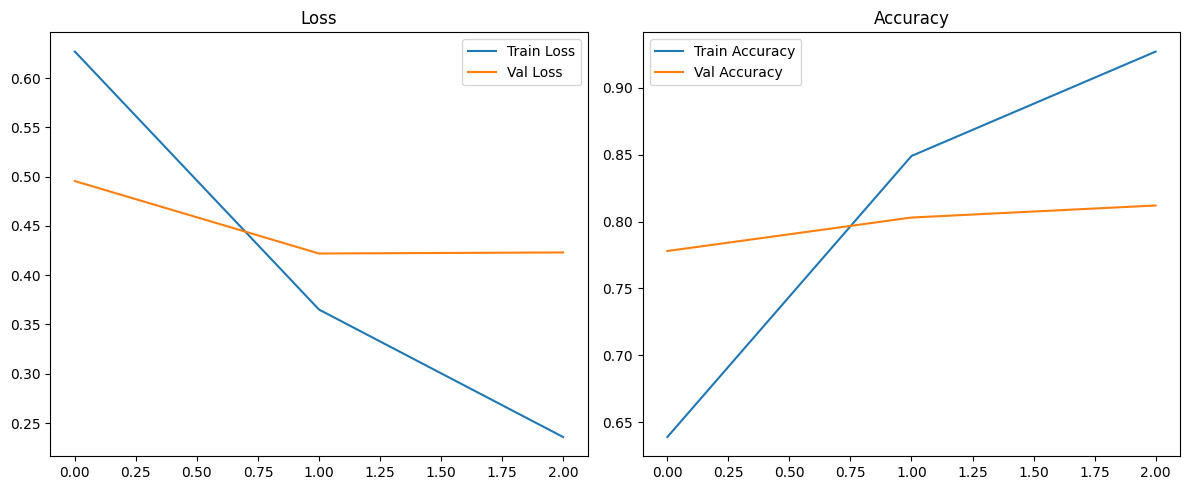

In [ ]:
import os
output_dir = './model_save/'
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to {output_dir}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

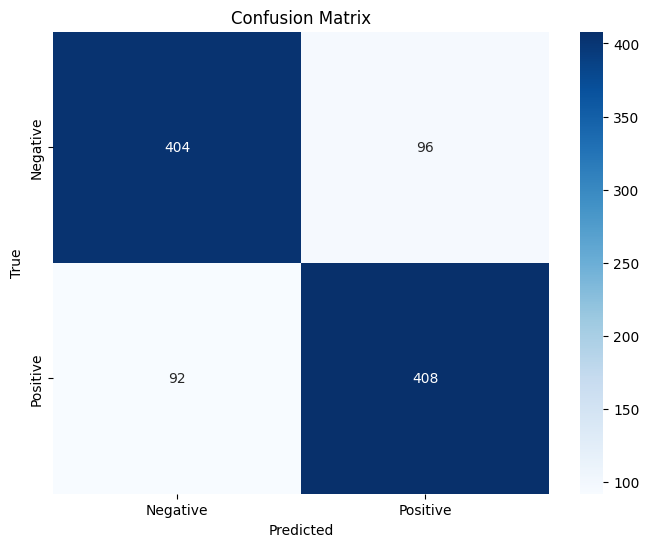

In [ ]:
# Confusion Matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.show()

# Attention analysis function
def analyze_attention(text, model, tokenizer, device):
    encoding = tokenizer(text, truncation=True, max_length=max_len, padding='max_length', return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    attentions = outputs.attentions
    pred = torch.argmax(logits, dim=1).item()
    pred_label = "Positive" if pred == 1 else "Negative"
    confidence = F.softmax(logits, dim=1)[0][pred].item()
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    attn_last_layer = attentions[-1].mean(dim=1).cpu().numpy()[0]

    plt.figure(figsize=(10, 8))
    sns.heatmap(attn_last_layer, cmap='viridis')
    plt.title(f'Attention Weights (Pred: {pred_label}, Conf: {confidence:.2f})')
    plt.xlabel('Token Pos')
    plt.ylabel('Token Pos')
    plt.savefig('attention_weights.png')
    plt.show()

    print("\nTop attended tokens:")
    for i, token in enumerate(tokens):
        if token == '[PAD]': continue
        attention_weights = attn_last_layer[i]
        top_indices = np.argsort(attention_weights)[-5:][::-1]
        top_tokens = [tokens[idx] for idx in top_indices]
        top_weights = attention_weights[top_indices]
        print(f"Token '{token}' → {', '.join([f'{t} ({w:.3f})' for t, w in zip(top_tokens, top_weights)])}")

    return pred_label, confidence


Analyzing attention for sample text:


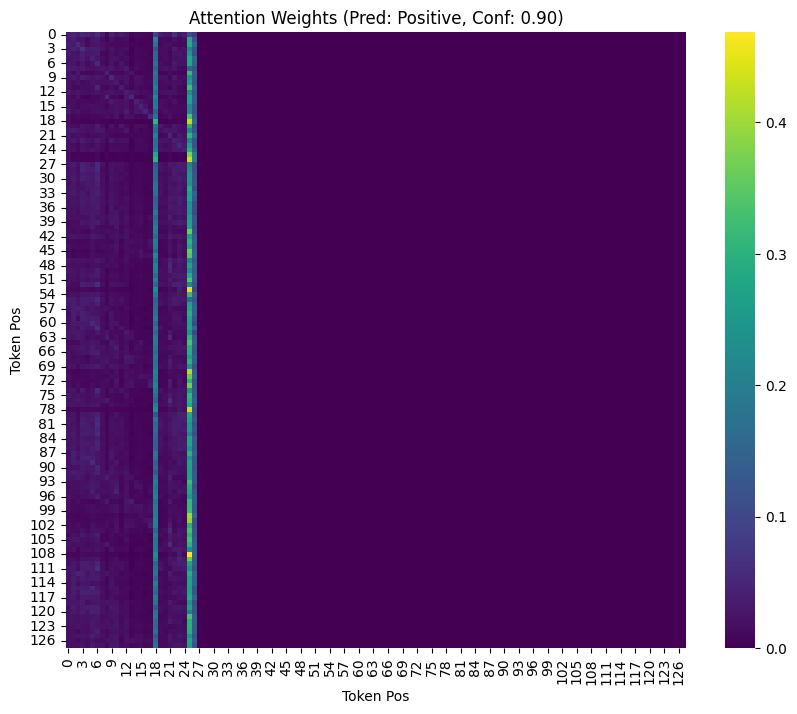


Top attended tokens:
Token '[CLS]' → . (0.105), , (0.089), [SEP] (0.074), was (0.061), ! (0.057)
Token 'this' → . (0.282), , (0.204), [SEP] (0.122), this (0.038), ! (0.033)
Token 'movie' → . (0.286), , (0.169), [SEP] (0.157), movie (0.056), [CLS] (0.035)
Token 'was' → . (0.207), [SEP] (0.125), , (0.118), was (0.068), this (0.045)
Token 'absolutely' → . (0.249), , (0.154), [SEP] (0.111), was (0.039), ! (0.035)
Token 'fantastic' → . (0.281), [SEP] (0.156), , (0.150), fantastic (0.042), was (0.038)
Token '!' → . (0.279), , (0.170), [SEP] (0.148), ! (0.053), was (0.031)
Token 'the' → . (0.150), , (0.146), [SEP] (0.115), [CLS] (0.037), was (0.033)
Token 'plot' → . (0.316), , (0.180), [SEP] (0.138), plot (0.042), movie (0.030)
Token 'was' → . (0.247), , (0.160), [SEP] (0.130), was (0.053), was (0.040)
Token 'engaging' → . (0.261), , (0.167), [SEP] (0.124), engaging (0.033), fantastic (0.025)
Token ',' → . (0.325), , (0.194), [SEP] (0.145), ! (0.048), , (0.035)
Token 'the' → . (0.222), , (0.

In [ ]:
sample_text = "This movie was absolutely fantastic! The plot was engaging, the characters were well-developed, and the cinematography was breathtaking."
print("\nAnalyzing attention for sample text:")
pred_label, confidence = analyze_attention(sample_text, model, tokenizer, device)
print(f"Prediction: {pred_label} (Confidence: {confidence:.2f})")


Analyzing attention for sample text:


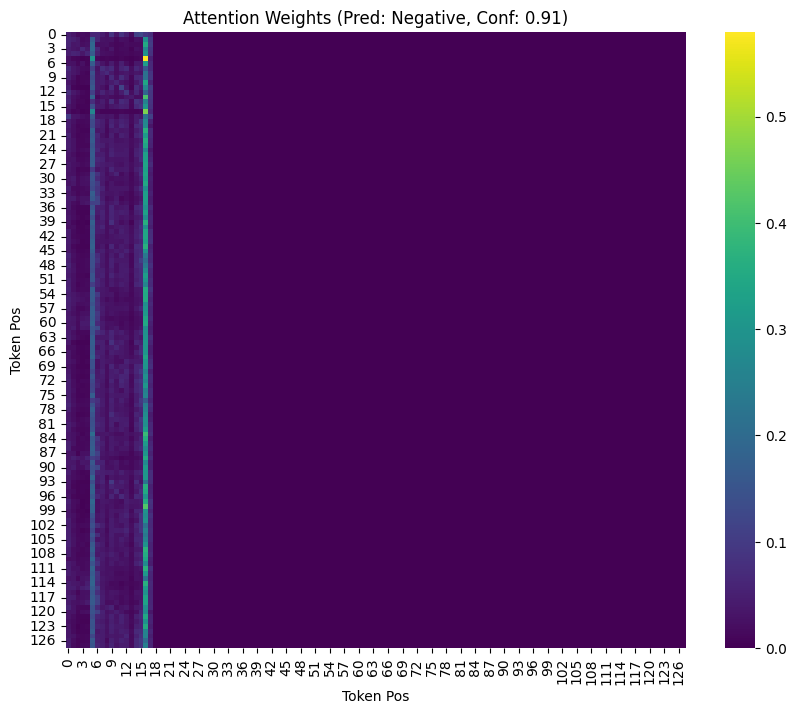


Top attended tokens:
Token '[CLS]' → inconsistent (0.124), was (0.113), . (0.089), felt (0.086), and (0.086)
Token 'the' → . (0.284), , (0.170), [SEP] (0.096), but (0.059), [CLS] (0.058)
Token 'movie' → . (0.350), , (0.191), [SEP] (0.103), [CLS] (0.056), movie (0.037)
Token 'had' → . (0.271), , (0.193), [SEP] (0.090), had (0.063), but (0.063)
Token 'potential' → . (0.297), , (0.167), [SEP] (0.086), potential (0.059), the (0.058)
Token ',' → . (0.579), , (0.295), [SEP] (0.053), [CLS] (0.024), but (0.012)
Token 'but' → . (0.321), , (0.166), [SEP] (0.067), but (0.060), and (0.049)
Token 'the' → . (0.153), , (0.110), the (0.074), the (0.069), felt (0.069)
Token 'storyline' → . (0.219), , (0.143), [SEP] (0.089), storyline (0.069), the (0.054)
Token 'felt' → . (0.214), , (0.131), [SEP] (0.091), and (0.074), felt (0.069)
Token 'rushed' → . (0.341), , (0.145), inconsistent (0.068), [SEP] (0.061), rushed (0.059)
Token 'and' → . (0.269), , (0.160), and (0.117), [SEP] (0.102), was (0.071)
Token 

In [ ]:
sample_text = "The movie had potential, but the storyline felt rushed and the acting was inconsistent."
print("\nAnalyzing attention for sample text:")
pred_label, confidence = analyze_attention(sample_text, model, tokenizer, device)
print(f"Prediction: {pred_label} (Confidence: {confidence:.2f})")